In [2]:
import pickle

path = './data/openai_gpt_temp=1.0_reas=False_agg=original_final_results.pkl'
with open(path, 'rb') as infile:
    results = pickle.load(infile)

/home/jahanpd/envs/llm/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [38]:
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import pickle

validation = pd.read_csv("responses_test_rows.csv")
data = validation[validation.created_at > "2024-11-19"]
data = data[[x in (112,113,111) for x in data.clinician]]



path = './data/openai_gpt_oneshot=False_temp=1.0_reas=False_agg=original_confidence.pkl'
with open(path, 'rb') as infile:
    scores = pickle.load(infile)

path = './data/openai_gpt_oneshot=False_temp=1.0_reas=False_checker=gpt_correctness.pkl'
with open(path, 'rb') as infile:
    correctness = pickle.load(infile)

# scores
perp = [[x['perplexity'] for x in scores if x['ids'] == ids][0] for ids in data.question_id]
entropy = [[x['entropy'] for x in scores if x['ids'] == ids][0] for ids in data.question_id]

# get human validated correctness for perplexity 
val_perp = data.gpt_correct.astype(np.float32)
llm_perp = [[x['perplexity_correct'] for x in correctness if x['id'] == ids][0] for ids in data.question_id]

# get human validated correctness for clusters 
val_clust = np.array([not pd.isnull(x) and x == y for x, y in zip(data.group_correct, data.gpt_correct_group)]).astype(np.float32)
llm_clust = [[x['cluster_correct_lowest'] for x in correctness if x['id'] == ids][0] for ids in data.question_id]

def auc(score, correct):
    AUC = roc_auc_score(
        np.array(correct).astype(np.float32),
        -1*np.array(score).astype(np.float32)
    )
    # Hanley and McNeil, The meaning and use of the area under a receiver operating characteristic (ROC) curve. Radiology (1982) 43 (1) pp. 29-36.
    N1 = np.sum([c for c in correct])
    N2 = np.sum([not c for c in correct])
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = np.sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return AUC, lower, upper

print(
    auc(perp, val_perp),
    auc(perp, llm_perp),
    auc(entropy, val_clust),
    auc(entropy, llm_clust),
    )



0.5652680652680653 0.6988400994200497 0.9660493827160495 0.8367854183927093


In [32]:
correctness

[{'id': 3,
  'cluster_correct_strict': True,
  'cluster_correct_relaxed': True,
  'cluster_correct_majority': True,
  'cluster_correct_lowest': True,
  'cluster_correct_oneshot_all': True,
  'cluster_correct_oneshot_most': True,
  'perplexity_correct': True,
  'question': 'Which structure is attached to the lateral aspect of the cervix and the lateral wall of the pelvis and is one of the main supports of the uterus?',
  'answers': ['The cardinal ligament.',
   'The cardinal ligament.',
   'The cardinal (or transverse cervical) ligament.',
   'The cardinal ligament.',
   'The cardinal ligament.',
   'The uterosacral ligament supports the uterus laterally.',
   'The cardinal ligament.',
   'The cardinal ligament supports the uterus laterally.',
   'The cardinal ligament.',
   'The cardinal ligament.'],
  'true_answer': 'Transverse cervical ligament',
  'answer_labels': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  'perplexity': [1.1879134615807878,
   1.1682210098289356,
   1.723889303473659,
   1.1

In [9]:
import pickle

path = './data/openai_gpt_oneshot=False_reas=False_temp=1.0_semantic_similarity.pkl' 
with open(path, 'rb') as infile:
    results = pickle.load(infile)

count_1 = 0
count_2 = 0
for key, value in results.items():
    groups = len(set([v for k,v in value.items()]))
    if groups == 1:
        count_1 += 1
    if groups == 2:
        count_2 += 1

print((count_1 + count_2)/len(results))

0.6946107784431138


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np

negent = -1*np.array(results["entropy"])
ent_correct = np.array(results["entropy_correct"]).astype(np.float32)

negdent = -1*np.array(results["dentropy"])
dent_correct = np.array(results["dentropy_correct"]).astype(np.float32)

neg_og_ent = -1*np.array(results["og_entropy"])
og_ent_correct = np.array(results["og_entropy_correct"]).astype(np.float32)

negperp = -1*np.array(results["perplexity"])
perp_correct = np.array(results["perplexity_correct"]).astype(np.float32)

df = pd.DataFrame({
    'SE':negent, 
    'SE_correct':ent_correct, 
    'DSE':negdent, 
    'DSE_correct':dent_correct, 
    'OSE':neg_og_ent, 
    'OSE_correct':og_ent_correct, 
    'Perplexity':negperp, 
    'Perp_correct':perp_correct, 
    })
df

,SE,SE_correct,DSE,DSE_correct,OSE,OSE_correct,Perplexity,Perp_correct
0,21.427737,1.0,0.000000,1.0,-2.747399,1.0,-1.020888,1.0
1,23.002700,1.0,0.000000,1.0,-2.698116,1.0,-1.000657,1.0
2,18.966560,1.0,0.000000,1.0,-2.831403,1.0,-1.062587,1.0
3,20.102337,1.0,0.000000,1.0,-2.791484,1.0,-1.015804,1.0
4,23.004013,1.0,0.000000,1.0,-2.698076,1.0,-1.000398,1.0
...,...,...,...,...,...,...,...,...
1819,15.945436,0.0,0.000000,0.0,-2.949104,0.0,-1.257295,0.0
1820,13.542348,0.0,-0.325083,0.0,-4.243138,0.0,-1.157764,0.0
1821,4.896908,0.0,-0.943348,0.0,-4.533342,1.0,-1.815681,0.0
1822,19.542671,0.0,0.000000,0.0,-2.810893,0.0,-1.033990,0.0


Text(0.5, 1.0, 'Perplexity')

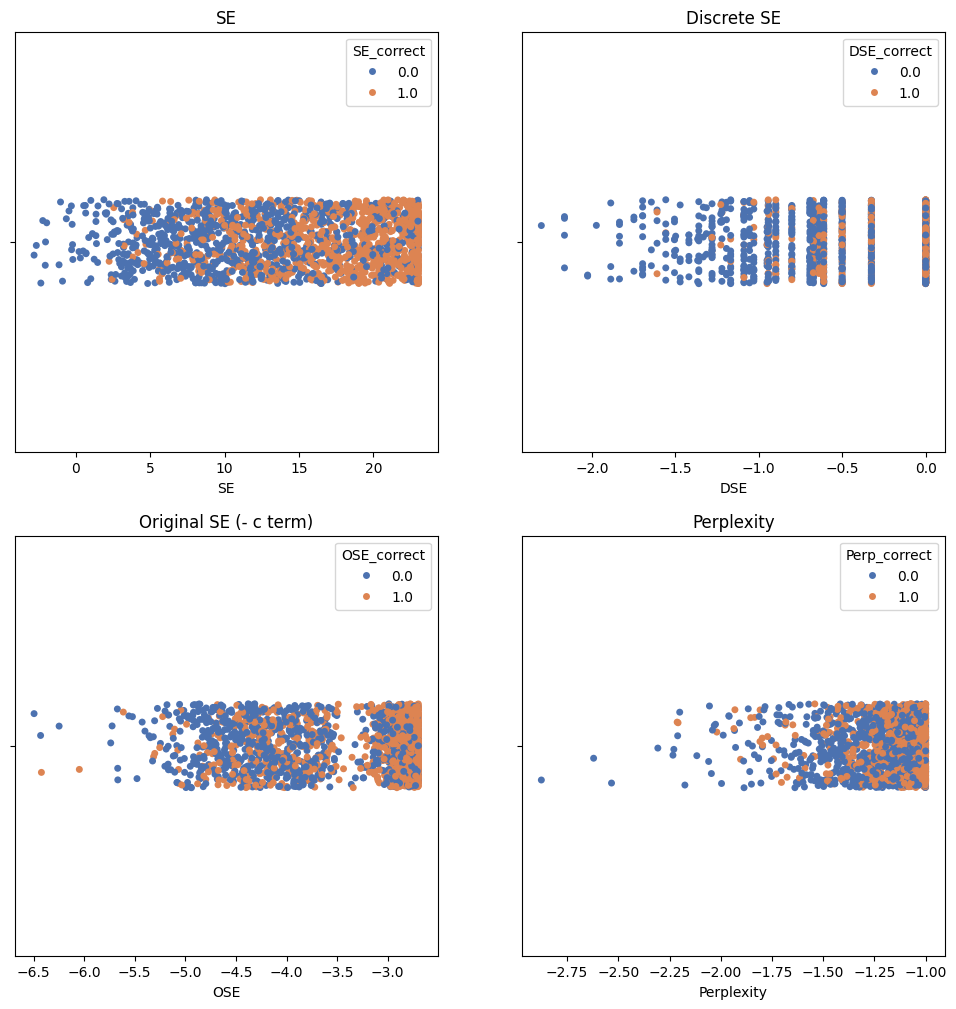

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.stripplot(data=df, x="SE", hue="SE_correct", palette="deep", ax=axes[0,0])
axes[0,0].set_title("SE")
sns.stripplot(data=df, x="DSE", hue="DSE_correct", palette="deep", ax=axes[0,1])
axes[0,1].set_title("Discrete SE")
sns.stripplot(data=df, x="OSE", hue="OSE_correct", palette="deep", ax=axes[1,0])
axes[1,0].set_title("Original SE (- c term)")
sns.stripplot(data=df, x="Perplexity", hue="Perp_correct", palette="deep", ax=axes[1,1])
axes[1,1].set_title("Perplexity")